In [ ]:
#| default_exp core

# Source

> Source code for fastlite

## Metadata

In [ ]:
#| export
from dataclasses import field, make_dataclass, fields, Field, is_dataclass, MISSING
from typing import Any,Union,Optional

from fastcore.utils import *
from fastcore.xml import highlight
from fastcore.xtras import hl_md, dataclass_src

from sqlite_utils import Database
from sqlite_utils.db import Table, View

try: from graphviz import Source
except ImportError: pass

In [ ]:
from IPython.display import Markdown

In [ ]:
db = Database("chinook.sqlite")

In [ ]:
#| exports
class _Getter:
    "Abstract class with dynamic attributes providing access to DB objects"
    def __init__(self, db): self.db = db
    # NB: Define `__dir__` in subclass to get list of objects
    def __repr__(self): return ", ".join(dir(self))
    def __contains__(self, s): return (s if isinstance(s,str) else s.name) in dir(self)
    def __getitem__(self, idxs):
        if isinstance(idxs,str): idxs = [idxs]
        return [self.db.table(o) for o in idxs]
    def __getattr__(self, k):
        if k[0]=='_': raise AttributeError
        return self.db[k]

class _TablesGetter(_Getter):
    def __dir__(self): return self.db.table_names()

@patch(as_prop=True)
def t(self:Database): return _TablesGetter(self)

By returning a `_TablesGetter` we get a repr and auto-complete that shows all tables in the DB.

In [ ]:
dt = db.t
dt

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

In [ ]:
artist = dt.Artist
artist

<Table Artist (ArtistId, Name)>

This also can be used to get multiple tables at once.

In [ ]:
dt['Album','Artist']

[<Table Album (AlbumId, Title, ArtistId)>, <Table Artist (ArtistId, Name)>]

In [ ]:
assert 'Artist' in dt
assert artist in dt
assert 'foo' not in dt

In [ ]:
#| exports
class _Col:
    def __init__(self, t, c): self.t,self.c = t,c
    def __str__(self):  return f'"{self.t}"."{self.c}"'
    def __repr__(self):  return self.c

class _ColsGetter:
    def __init__(self, tbl): self.tbl = tbl
    def __dir__(self): return map(repr, self())
    def __call__(self): return [_Col(self.tbl.name,o.name) for o in self.tbl.columns]
    def __contains__(self, s): return (s if isinstance(s,str) else s.c) in self.tbl.columns_dict
    def __repr__(self): return ", ".join(dir(self))

    def __getattr__(self, k):
        if k[0]=='_': raise AttributeError
        return _Col(self.tbl.name, k)

@patch(as_prop=True)
def c(self:Table): return _ColsGetter(self)

@patch(as_prop=True)
def c(self:View): return _ColsGetter(self)

Column auto-complete and repr are much the same as tables.

In [ ]:
ac = artist.c
ac

ArtistId, Name

Columns stringify in a format suitable for including in SQL statements.

In [ ]:
print(f"select {ac.Name} ...")

select "Artist"."Name" ...


In [ ]:
#| exports
@patch
def __str__(self:Table): return f'"{self.name}"'

@patch
def __str__(self:View): return f'"{self.name}"'

Tables and views do the same.

In [ ]:
print(f"select {ac.Name} from {artist}")

select "Artist"."Name" from "Artist"


In [ ]:
assert 'Name' in ac
assert ac.Name in ac
assert 'foo' not in ac

## Queries and views

In [ ]:
#| exports
@patch
def q(self:Database, sql: str, params = None)->list:
    return list(self.query(sql, params=params))

This is a minor shortcut for interactive use.

In [ ]:
acdc = db.q(f"select * from {artist} where {ac.Name} like 'AC/%'")
acdc

[{'ArtistId': 1, 'Name': 'AC/DC'}]

In [ ]:
#| exports
def _get_flds(tbl): 
    return [(k, v|None, field(default=tbl.default_values.get(k,None)))
            for k,v in tbl.columns_dict.items()]

@patch
def dataclass(self:Table, store=True, suf='')->type:
    "Create a `dataclass` with the types and defaults of this table"
    res = make_dataclass(self.name.title()+suf, _get_flds(self))
    if store: self.cls = res
    return res

In [ ]:
artist_dc = artist.dataclass()
art1_obj = artist_dc(**acdc[0])
art1_obj

Artist(ArtistId=1, Name='AC/DC')

You can get the definition of the dataclass using fastcore's `dataclass_src`:

In [ ]:
src = dataclass_src(artist_dc)
hl_md(src, 'python')

```python
@dataclass
class Artist:
    ArtistId: int | None = None
    Name: str | None = None

```

In [ ]:
#| exports
def all_dcs(db, with_views=False, store=True, suf=''):
    "dataclasses for all objects in `db`"
    return [o.dataclass(store=store, suf=suf) for o in db.tables + (db.views if with_views else [])]

In [ ]:
#| exports
def create_mod(db, mod_fn, with_views=False, store=True, suf=''):
    "Create module for dataclasses for `db`"
    mod_fn = str(mod_fn)
    if not mod_fn.endswith('.py'): mod_fn+='.py'
    with open(mod_fn, 'w') as f:
        print('from dataclasses import dataclass', file=f)
        print('from typing import Any,Union,Optional\n', file=f)
        for o in all_dcs(db, with_views, store=store, suf=suf): print(dataclass_src(o), file=f)

In [ ]:
create_mod(db, 'db_dc')

In [ ]:
#| eval: false
from db_dc import Track
Track(**dt.Track.get(1))

Track(TrackId=1, Name='For Those About To Rock (We Salute You)', AlbumId=1, MediaTypeId=1, GenreId=1, Composer='Angus Young, Malcolm Young, Brian Johnson', Milliseconds=343719, Bytes=11170334, UnitPrice=0.99)

In [ ]:
#| exports
@patch
def __call__(
    self:(Table|View), with_pk:bool=False, where:str|None=None,
    where_args: Iterable|dict|NoneType=None, order_by: str|None=None,
    limit:int|None=None, offset:int|None=None, as_cls:bool=True, **kwargs)->list:
    "Shortcut for `rows_where` or `pks_and_rows_where`, depending on `with_pk`"
    
    f = getattr(self, 'pks_and_rows_where' if with_pk else 'rows_where')
    res = f(where=where, where_args=where_args, order_by=order_by, limit=limit, offset=offset, **kwargs)
    if as_cls and hasattr(self,'cls'):
        if with_pk: res = ((k,self.cls(**v)) for k,v in res)
        else: res = (self.cls(**o) for o in res)
    return list(res)

This calls either `rows_where` (if `with_pk`) or `with_pk` (otherwise). If `dataclass(store=True)` has been called, then if `as_cls` rows will be returned as dataclass objects.

In [ ]:
artist(limit=2)

[Artist_cls(ArtistId=1, Name='AC/DC'), Artist_cls(ArtistId=2, Name='Accept')]

If `with_pk` then tuples are returns with PKs 1st.

In [ ]:
artist(True, limit=2)

[(1, Artist_cls(ArtistId=1, Name='AC/DC')),
 (2, Artist_cls(ArtistId=2, Name='Accept'))]

In [ ]:
#| exports
@patch
def get(self:Table, pk_values: list|tuple|str|int, as_cls:bool=True)->Any:
    res = self._orig_get(pk_values=pk_values)
    if as_cls and hasattr(self,'cls'): res = self.cls(**res)
    return res

In [ ]:
artist.get(1)

Artist_cls(ArtistId=1, Name='AC/DC')

In [ ]:
album = dt.Album

acca_sql = f"""select {album}.*
from {album} join {artist} using (ArtistId)
where {ac.Name} like 'AC/%'"""

In [ ]:
hl_md(acca_sql, 'sql')

```sql
select "Album".*
from "Album" join "Artist" using (ArtistId)
where "Artist"."Name" like 'AC/%'
```

In [ ]:
db.q(acca_sql)

[{'AlbumId': 1,
  'Title': 'For Those About To Rock We Salute You',
  'ArtistId': 1},
 {'AlbumId': 4, 'Title': 'Let There Be Rock', 'ArtistId': 1}]

In [ ]:
db.create_view("AccaDaccaAlbums", acca_sql, replace=True)

<Database <sqlite3.Connection object>>

In [ ]:
#| exports
class _ViewsGetter(_Getter):
    def __dir__(self): return self.db.view_names()

@patch(as_prop=True)
def v(self:Database): return _ViewsGetter(self)

In [ ]:
dv = db.v
dv

AccaDaccaAlbums

In [ ]:
dv.AccaDaccaAlbums()

[{'AlbumId': 1,
  'Title': 'For Those About To Rock We Salute You',
  'ArtistId': 1},
 {'AlbumId': 4, 'Title': 'Let There Be Rock', 'ArtistId': 1}]

## Database diagrams

(Requires graphviz.)

In [ ]:
fk = album.foreign_keys[0]
fk

ForeignKey(table='Album', column='ArtistId', other_table='Artist', other_column='ArtistId')

In [ ]:
#| exports
def _edge(tbl):
    return "\n".join(f"{fk.table}:{fk.column} -> {fk.other_table}:{fk.other_column};"
                     for fk in tbl.foreign_keys)

def _row(col):
    xtra = " 🔑" if col.is_pk else ""
    bg = ' bgcolor="#ffebcd"' if col.is_pk else ""
    return f'    <tr><td port="{col.name}"{bg}>{col.name}{xtra}</td></tr>'

def _tnode(tbl):
    rows = "\n".join(_row(o) for o in tbl.columns)
    res = f"""<table cellborder="1" cellspacing="0">
    <tr><td bgcolor="lightgray">{tbl.name}</td></tr>
{rows}
  </table>"""
    return f"{tbl.name} [label=<{res}>];\n"

In [ ]:
#| exports
def diagram(tbls, ratio=0.7, size="10", neato=False, render=True):
    layout = "\nlayout=neato;\noverlap=prism;\noverlap_scaling=0.5;""" if neato else ""
    edges  = "\n".join(map(_edge,  tbls))
    tnodes = "\n".join(map(_tnode, tbls))
    
    res = f"""digraph G {{
rankdir=LR;{layout}
size="{size}";
ratio={ratio};
node [shape=plaintext]

{tnodes}

{edges}
}}
"""
    return Source(res) if render else res

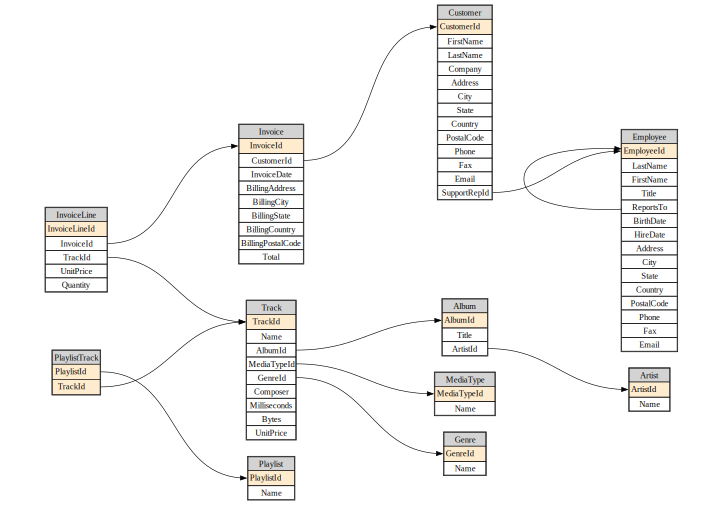

In [ ]:
diagram(db.tables)

## export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()